# APIM ❤️ OpenAI

## Backend pool Load Balancing lab (with Terraform)
![flow](../../images/backend-pool-load-balancing.gif)

Playground to try the built-in load balancing [backend pool functionality of APIM](https://learn.microsoft.com/azure/api-management/backends?tabs=bicep) to a list of Azure OpenAI endpoints.

Notes:
- **This is a typical prioritized PTU with fallback consumption scenario**. The lab specifically showcases how a priority 1 (highest) backend is exhausted before gracefully falling back to two equally-weighted priority 2 backends.
- The backend pool uses round-robin by default.
- Priority and weight-based routing are supported and can be adjusted by modifying `priority` (the lower the number, the higher the priority) and `weight` variables in the `openai_resources` variable below.
- The `retry` API Management policy initiates a retry to an available backend if an HTTP 429 status code is encountered. This is transparent to the caller.

### Result
![result](result.png)

### TOC
- [0️⃣ Initialize notebook variables](#0)
- [1️⃣ Verify the Azure CLI and the connected Azure subscription](#1)
- [2️⃣ Create deployment using Terraform](#2)
- [3️⃣ Get the deployment outputs](#3)
- [🧪 Test the API using a direct HTTP call](#requests)
- [🔍 Analyze Load Balancing results](#plot)
- [🧪 Test the API using the Azure OpenAI Python SDK](#sdk)
- [🗑️ Clean up resources](#clean)

### Prerequisites
- [Python 3.12 or later version](https://www.python.org/) installed
- [Pandas Library](https://pandas.pydata.org/) and matplotlib installed
- [VS Code](https://code.visualstudio.com/) installed with the [Jupyter notebook extension](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter) enabled
- [Azure CLI](https://learn.microsoft.com/cli/azure/install-azure-cli) installed
- [An Azure Subscription](https://azure.microsoft.com/free/) with Contributor permissions
- [Access granted to Azure OpenAI](https://aka.ms/oai/access) or just enable the mock service
- [Sign in to Azure with Azure CLI](https://learn.microsoft.com/cli/azure/authenticate-azure-cli-interactively)
- [Terraform CLI](https://learn.hashicorp.com/tutorials/terraform/install-cli) installed

<a id='0'></a>
### 0️⃣ Initialize notebook variables

- Resources will be suffixed by a unique random string.
- Adjust the location variables according your preferences and on the [product availability by Azure region.](https://azure.microsoft.com/explore/global-infrastructure/products-by-region/?cdn=disable&products=cognitive-services,api-management)
- Adjust the OpenAI model and version according the [availability by region.](https://learn.microsoft.com/azure/ai-services/openai/concepts/models) 

In [ ]:
import os, sys, json
sys.path.insert(1, '../../shared')  # add the shared directory to the Python path
import utils

deployment_name = os.path.basename(os.path.dirname(globals()['__vsc_ipynb_file__']))
# resource_group_name = f"lab-{deployment_name}" # change the name to match your naming style
resource_group_name = f"gab-melb-backend-pool-load-balance" # change the name to match your naming style
resource_group_location = "australiaeast"

apim_sku = "BasicV2"

# Prioritize UK South until exhaustion (simulate PTU with TPM), then equally distribute between Sweden and France (consumption fallback)
openai_resources = """{
    openai-uks = {
      name     = "openai1",
      location = "australiaeast",
      priority = 1,
      weight   = 100
    },
    openai-swc = {
      name     = "openai2",
      location = "eastus",
      priority = 2,
      weight   = 75
    },
    openai-frc = {
      name     = "openai3",
      location = "southindia",
      priority = 2,
      weight   = 25
    }
  }
"""

openai_deployment_name = "gpt-4o"
openai_model_name = "gpt-4o"
openai_model_version = "2024-08-06"
openai_model_capacity = 8
openai_api_version = "2024-10-21"

utils.print_ok('Notebook initialized')

✅ Notebook initialized ⌚ 20:40:48.823182 


<a id='1'></a>
### 1️⃣ Verify the Azure CLI and the connected Azure subscription

The following commands ensure that you have the latest version of the Azure CLI and that the Azure CLI is connected to your Azure subscription.

In [18]:
output = utils.run("az account show", "Retrieved az account", "Failed to get the current az account")

if output.success and output.json_data:
    current_user = output.json_data['user']['name']
    tenant_id = output.json_data['tenantId']
    subscription_id = output.json_data['id']

    utils.print_info(f"Current user: {current_user}")
    utils.print_info(f"Tenant ID: {tenant_id}")
    utils.print_info(f"Subscription ID: {subscription_id}")

⚙️ Running: az account show 
✅ Retrieved az account ⌚ 20:40:51.441832 :2s]
👉🏽 Current user: nileshgule@outlook.com
👉🏽 Tenant ID: c5ec075b-004b-43dd-9cd6-07bfd286c174
👉🏽 Subscription ID: 065cf559-687c-4233-a331-564f10c8b9ed


<a id='2'></a>
### 2️⃣ Create deployment using Terraform

This lab uses [Terraform](https://learn.microsoft.com/en-us/azure/developer/terraform/overview) to declarative define all the resources that will be deployed in the specified resource group. Change the variables or the [main.tf](main.tf) directly to try different configurations.

`openAIModelCapacity` is set intentionally low to `8` (8k tokens per minute) to trigger the retry logic in the load balancer (transparent to the user) as well as the priority failover from priority 1 to 2.

Setup the variables for Terraform. Te following code will generate a terraform file called `terraform.tfvars` with the variables needed to deploy the resources.

In [19]:
# Define the Terraform variables
terraform_variables = f"""
resource_group_name     = "{resource_group_name}"
resource_group_location = "{resource_group_location}"
apim_sku                = "{apim_sku}"
openai_deployment_name  = "{openai_deployment_name}"
openai_model_name       = "{openai_model_name}"
openai_model_version    = "{openai_model_version}"
openai_model_capacity   = "{openai_model_capacity}"
openai_api_version      = "{openai_api_version}"
openai_config           = {openai_resources}
"""

# Write the variables to the terraform.tfvars file
with open("terraform.tfvars", "w") as terraform_variables_file:
    terraform_variables_file.write(terraform_variables)

utils.print_ok('terraform.tfvars file created')

✅ terraform.tfvars file created ⌚ 20:40:51.455887 


The terraform commands `terraform init` and `terraform apply` will be executed in order to deploy the resources.

In [20]:
# Intialize terraform
output = utils.run(
    f"terraform init",
    f"Initialization succeeded",
    f"Initialization failed",
)

# Specify the target subscription for Terraform
os.environ['ARM_SUBSCRIPTION_ID'] = subscription_id

# Run the deployment
output = utils.run(
    f"terraform apply -auto-approve -var-file=terraform.tfvars",
    f"Deployment succeeded",
    f"Deployment failed",
)

⚙️ Running: terraform init 
✅ Initialization succeeded ⌚ 20:40:54.030567 :2s]
⚙️ Running: terraform apply -auto-approve -var-file=terraform.tfvars 
✅ Deployment succeeded ⌚ 20:43:33.442341 :39s]


<a id='3'></a>
### 3️⃣ Get the deployment outputs

Retrieve the required outputs from the Terraform deployment.

In [21]:
apim_resource_gateway_url = utils.run("terraform output apim_resource_gateway_url").json_data
utils.print_info(f"apim_resource_gateway_url: {apim_resource_gateway_url}")

apim_subscription_key = utils.run("terraform output apim_subscription_key").json_data
utils.print_info(f"apim_subscription_key: {apim_subscription_key}")

⚙️ Running: terraform output apim_resource_gateway_url 
👉🏽 apim_resource_gateway_url: https://apim-tpyvni1x.azure-api.net
⚙️ Running: terraform output apim_subscription_key 
👉🏽 apim_subscription_key: 79a9728c141a4d4ebeb2b1efc461dc39


<a id='requests'></a>
### 🧪 Test the API using a direct HTTP call
Requests is an elegant and simple HTTP library for Python that will be used here to make raw API requests and inspect the responses. 

You will not see HTTP 429s returned as API Management's `retry` policy will select an available backend. If no backends are viable, an HTTP 503 will be returned.

Tip: Use the [tracing tool](../../tools/tracing.ipynb) to track the behavior of the backend pool.

In [ ]:
import requests, time

runs = 20
sleep_time_ms = 100
url = f"{apim_resource_gateway_url}/openai/deployments/{openai_deployment_name}/chat/completions?api-version={openai_api_version}"
messages = {"messages": [
    {"role": "system", "content": "You are a funny, helpful assistant."},
    {"role": "user", "content": "Can you tell me something about Global Azure Bootcamp Melbourne in 2 sentences, please?"}
]}
api_runs = []

# Initialize a session for connection pooling and set any default headers
session = requests.Session()
session.headers.update({'api-key': apim_subscription_key})

try:
    for i in range(runs):
        print(f"▶️ Run {i+1}/{runs}:")

        start_time = time.time()
        response = session.post(url, json = messages)
        response_time = time.time() - start_time
        print(f"⌚ {response_time:.2f} seconds")

        utils.print_response_code(response)

        if "x-ms-region" in response.headers:
            print(f"x-ms-region: \x1b[1;32m{response.headers.get("x-ms-region")}\x1b[0m") # this header is useful to determine the region of the backend that served the request
            api_runs.append((response_time, response.headers.get("x-ms-region")))

        if (response.status_code == 200):
            data = json.loads(response.text)
            print(f"Token usage: {json.dumps(dict(data.get("usage")), indent = 4)}\n")
            print(f"💬 {data.get("choices")[0].get("message").get("content")}\n")
        else:
            print(f"{response.text}\n")

        time.sleep(sleep_time_ms/1000)
finally:
    # Close the session to release the connection
    session.close()

▶️ Run 1/20:
⌚ 8.20 seconds
Response status: 200 - OK
x-ms-region: Australia East
Token usage: {
    "completion_tokens": 59,
    "completion_tokens_details": {
        "accepted_prediction_tokens": 0,
        "audio_tokens": 0,
        "reasoning_tokens": 0,
        "rejected_prediction_tokens": 0
    },
    "prompt_tokens": 31,
    "prompt_tokens_details": {
        "audio_tokens": 0,
        "cached_tokens": 0
    },
    "total_tokens": 90
}

💬 Oh sure, let me just whip out my magic crystal ball that knows the exact time wherever you are. Wouldn't it be easier to check a clock, your phone, or any electronic device nearby? But hey, if you really want me to guess, I'll say it's "hammer time".

▶️ Run 2/20:
⌚ 2.91 seconds
Response status: 200 - OK
x-ms-region: Australia East
Token usage: {
    "completion_tokens": 40,
    "completion_tokens_details": {
        "accepted_prediction_tokens": 0,
        "audio_tokens": 0,
        "reasoning_tokens": 0,
        "rejected_prediction_tokens"

<a id='plot'></a>
### 🔍 Analyze Load Balancing results

The priority 1 backend will be used until TPM exhaustion sets in, then distribution will occur near equally across the two priority 2 backends with 50/50 weights.  

Please note that the first request of the lab can take a bit longer and should be discounted in terms of duration.

In case the dependencies were not installed, you can install theme with the following command.

In [23]:
%pip install pandas
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


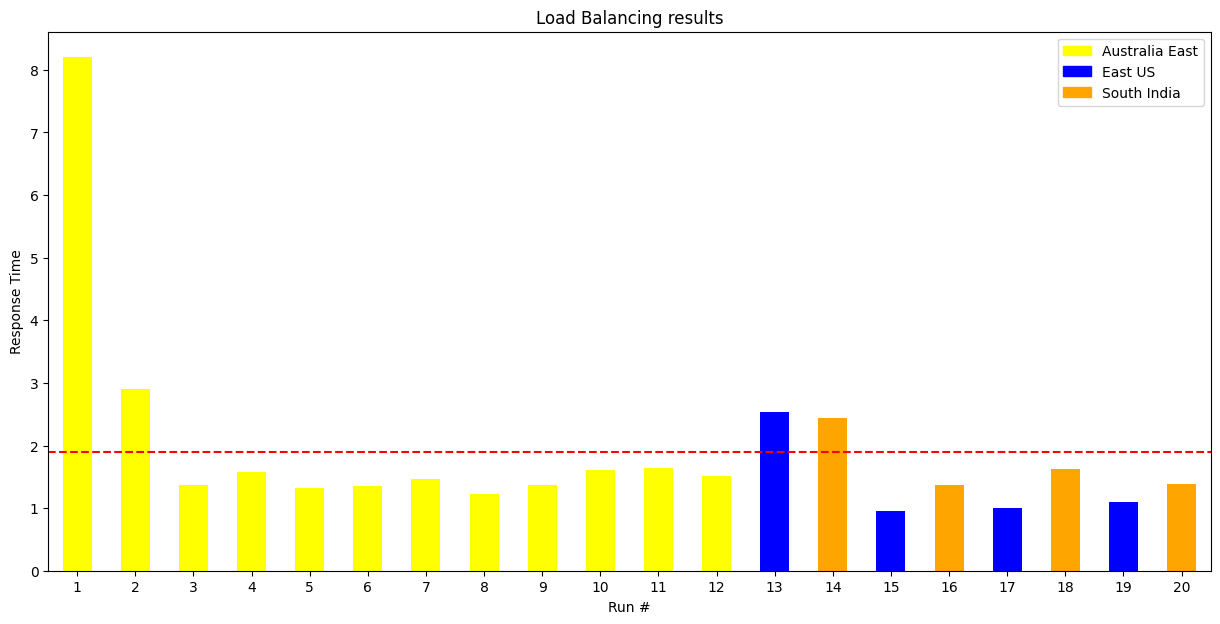

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle as pltRectangle
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [15, 7]
df = pd.DataFrame(api_runs, columns = ['Response Time', 'Region'])
df['Run'] = range(1, len(df) + 1)

# Define a color map for each region
color_map = {'Australia East': 'yellow', 'East US': 'blue', 'South India': 'orange'}  # Add more regions and colors as needed

# Plot the dataframe with colored bars
ax = df.plot(kind = 'bar', x = 'Run', y = 'Response Time', color = [color_map.get(region, 'gray') for region in df['Region']], legend = False)

# Add legend
legend_labels = [pltRectangle((0, 0), 1, 1, color = color_map.get(region, 'gray')) for region in df['Region'].unique()]
ax.legend(legend_labels, df['Region'].unique())

plt.title('Load Balancing results')
plt.xlabel('Run #')
plt.ylabel('Response Time')
plt.xticks(rotation = 0)

average = df['Response Time'].mean()
plt.axhline(y = average, color = 'r', linestyle = '--', label = f'Average: {average:.2f}')

plt.show()

<a id='sdk'></a>
### 🧪 Test the API using the Azure OpenAI Python SDK

Repeat the same test using the Python SDK to ensure compatibility. Note that we do not know what region served the response; we only see that we obtained a response.

In [ ]:
import time
from openai import AzureOpenAI

runs = 20
sleep_time_ms = 100

client = AzureOpenAI(
    azure_endpoint = apim_resource_gateway_url,
    api_key = apim_subscription_key,
    api_version = openai_api_version
)

for i in range(runs):
    print(f"▶️ Run {i+1}/{runs}:")

    start_time = time.time()
    raw_response = client.chat.completions.with_raw_response.create(
        model = openai_model_name,
        messages = [
            {"role": "system", "content": "You are a funny, helpful assistant."},
            {"role": "user", "content": "Can you tell me something interesting about Global Azure Bootcamp Melbourne, please?"}
        ])

    response_time = time.time() - start_time

    print(f"⌚ {response_time:.2f} seconds")
    print(f"x-ms-region: \x1b[1;32m{raw_response.headers.get("x-ms-region")}\x1b[0m") # this header is useful to determine the region of the backend that served the request

    response = raw_response.parse()

    if response.usage:
        print(f"Token usage:\n   Total tokens: {response.usage.total_tokens}\n   Prompt tokens: {response.usage.prompt_tokens}\n   Completion tokens: {response.usage.completion_tokens}\n")

    print(f"💬 {response.choices[0].message.content}\n")

    time.sleep(sleep_time_ms/1000)

▶️ Run 1/20:
⌚ 3.27 seconds
x-ms-region: Australia East
Token usage:
   Total tokens: 92
   Prompt tokens: 37
   Completion tokens: 55

💬 Global Azure Bootcamp Melbourne is an annual community-driven event where participants gather to learn and share knowledge about Microsoft's Azure platform through workshops and hands-on labs. It's a fantastic opportunity for both beginners and experts to network, gain new skills, and explore the latest in cloud technology.

▶️ Run 2/20:
⌚ 2.40 seconds
x-ms-region: Australia East
Token usage:
   Total tokens: 89
   Prompt tokens: 37
   Completion tokens: 52

💬 Global Azure Bootcamp Melbourne is an annual community-driven event that brings together Azure enthusiasts and professionals for a day of learning and networking. Participants can expect hands-on workshops, insightful talks from industry experts, and opportunities to connect with fellow Azure developers and cloud specialists.

▶️ Run 3/20:
⌚ 1.68 seconds
x-ms-region: Australia East
Token usage:

<a id='clean'></a>
### 🗑️ Clean up resources

When you're finished with the lab, you should remove all your deployed resources from Azure to avoid extra charges and keep your Azure subscription uncluttered.
Use the [clean-up-resources notebook](clean-up-resources.ipynb) for that.